In [1]:
import torch
from dynamic_model.model import DynamicsLookAheadModel
from dynamic_model.transforms import NormalizeTransform
from envs.IBGym_mod_envs import IBGymModded, IBGymQ
import numpy as np
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt

## Init Model and env

In [2]:
device = 'cuda'


model_path = 'dynamic_model/model'
# num_of_features = 6
# seq_len = 30
# hidden_size = 8
# out_size = 2
# look_ahead = 0
# n_layers = 1
# dropout_p = 0.2
#
#
# model = DynamicsLookAheadModel(features=num_of_features, hidden_size=hidden_size, out_size=out_size,
#                                batch_size=1, seq_len=seq_len, n_layers=n_layers, dropout_p=dropout_p,
#                                look_ahead=look_ahead).to(device)
model = torch.load(model_path).to(device)
model.eval()
model.look_ahead = 0
#model.load_state_dict(torch.load(model_path))
normalize_dataset = NormalizeTransform.load('dynamic_model/NormalizeInputConfigs.pkl')
normalize_dataset.to(device)
print(normalize_dataset.__dict__)
env = IBGymQ(q_model=model,device=device, setpoint=70, reward_type='classic', action_type='discrete', observation_type='include_past',
             reset_after_timesteps=1000, n_past_timesteps=model.seq_len, normalize_transformer=normalize_dataset)

{'save_path': 'NormalizeInputConfigs', 'mean': tensor([[[ 70.0000,  50.5296,  50.2879,  49.8275,  40.0748, 226.5551]]],
       device='cuda:0'), 'std': tensor([[[  0.0000,  17.5729,  31.5998,  30.0910,  37.5688, 232.3885]]],
       device='cuda:0')}


/home/hamza/PycharmProjects/StateCompression/venv/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [3]:
env.reset()
env.action_space.n

27

In [4]:
#np.zeros([env.observation_space.n, env.action_space.n])


In [5]:
def add_new_state(state, q_table):
    if not state in q_table:
        q_table[state] = np.zeros(env.action_space.n)



In [6]:
alpha = 0.001
gamma = 0.9
epsilon = 0.01
q_table = {}
# For plotting metrics
all_epochs = []
all_penalties = []
mean_reward_per_epoch = []
state_space_size = []

In [7]:


for i in range(1, 1200):
    state = env.reset()
    add_new_state(state,q_table)
    epochs, penalties, reward, = 0, 0, 0
    done = False
    total_reward=0
    while not done:

        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action)
        total_reward +=reward

        add_new_state(next_state,q_table)
        old_value = q_table[state][action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state][action] = new_value

        state = next_state
        epochs += 1

    if i % 1 == 0:

        clear_output(wait=True)
        mean_reward_per_epoch.append(total_reward/env.reset_after_timesteps)
        state_space_size.append(len(q_table.keys()))
        print(f'Mean Reward: {mean_reward_per_epoch[-1]}')
        print(f'Total States: {state_space_size[-1]}')
        print(f"Episode: {i}")

print("Training finished.\n")

Mean Reward: -484.26564470847154
Total States: 2102
Episode: 1199
Training finished.



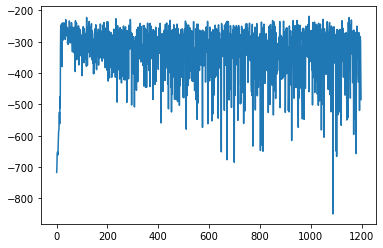

In [8]:
plt.plot(mean_reward_per_epoch)

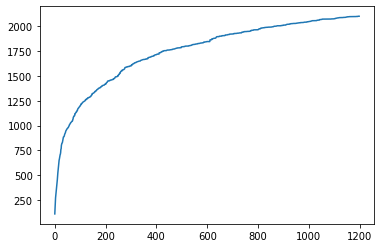

In [9]:
plt.plot(state_space_size)


In [10]:
total_epochs = 0
episodes = 10
avg_ep_reward = 0
for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0

    done = False
    total_rewards = 0
    while not done:
        add_new_state(state,q_table)
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)


        epochs += 1

        total_rewards += reward
    print((total_rewards/env.reset_after_timesteps))
    avg_ep_reward += (total_rewards/env.reset_after_timesteps)
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average Reward per episode: {avg_ep_reward / episodes}")

-506.92058338613595
-498.2232376490155
-370.7213246524124
-602.5909416731057
-420.6179181513799
-464.8275559304652
-382.38309615520274
-408.11929273259585
-360.0894509563777
-448.1453044120384
Results after 10 episodes:
Average timesteps per episode: 1000.0
Average Reward per episode: -446.26387056987295


In [11]:
print(q_table.keys())

dict_keys([69148, 69276, 68764, 199836, 197788, 201884, 70808, 69848, 266456, 266328, 331992, 790616, 790648, 790649, 790617, 823897, 823929, 561785, 569977, 569913, 586297, 586265, 586269, 586271, 588319, 588311, 588343, 588341, 588405, 588413, 588349, 586365, 586361, 569401, 536761, 536729, 536601, 537145, 537241, 553529, 619193, 619161, 651803, 586267, 586301, 653885, 588351, 588345, 653881, 653981, 588317, 588309, 588409, 585849, 561273, 36921, 4120, 266392, 266396, 266397, 266909, 791197, 529053, 561725, 561721, 569885, 569887, 586303, 651837, 588373, 577657, 36984, 4312, 4248, 4184, 528540, 528413, 790557, 528541, 790685, 528925, 561693, 569917, 654013, 569433, 569369, 585785, 585881, 585753, 570009, 840217, 561821, 570013, 537245, 586429, 654015, 653877, 586425, 5272, 12376, 12312, 13368, 132284, 203932, 204444, 202396, 69784, 12440, 798873, 537113, 553497, 200348, 77468, 77340, 76892, 76884, 207956, 208340, 470484, 470356, 470292, 470932, 208788, 208660, 225044, 225052, 216860,